# Practica: Redes convolucionales

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from MyUtils.plot import *

#%connect_info
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST

import torch.nn.functional as FUN

# Cifar 10 y redes convolucionales

La arquitectura que deberas implementar debe tener las siguientes caracteristicas:

    - Una capa convolucional de entrada con un filtro de 5x5x3 y 64 filtros de salida
    - Una capa de MaxPooling 
    - Otra capa convolucional con un filtro de 5x5x64 y 64 filtros de salida
    - Una capa de MaxPooling
    - Una capa completamente conectada con 384 neuronas,cuya activacion es ReLu
    - Una capa completamente conectada con 192 neuronas,cuya activacion es ReLu
    -Finalmente,una capa de salida con 10 neuronas
Es importante señalar que entre cada capa convolucional y de pooling existe una activacion **ReLu**

Graficamente, algo similar a lo mostrado en la siguiente figura:
<img src="AlexNet-cifar10.png" alt="Arquitectura de la red" title="Red convolucional" />

# Cifar 10
Es un conjunto de datos de imagenes que tiene 60,000 imagenes de 30x30 a color de 10 clases distintas (cada clase con 6,000 imagenes).
Las clases de este conjunto de datos corresponden a:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, y truck.

Para clasificar este conjunto de datos usaremos una red convolucional anteriormente descrita en Pytorch.

In [7]:
#Cargamos los datos de este conjunto en las variables correspondientes al igual que el caso de MNIST
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


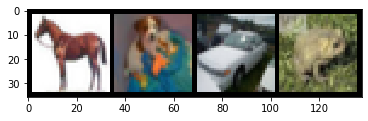

horse   dog   car  frog


In [8]:
#Mostrando imagen
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
#airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.
class CIFAR_NET(nn.Module):
    def __init__(self):
        '''Constructor de la red neuronal
        En esta funcion defines las operaciones que seran realizadas y 
        las agregas a self para tenerlas disponibles despues'''
        super(CIFAR_NET, self).__init__()
        
        #Toma en cuenta el constructor de las capas convolucionales
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,padding=0, dilation=1, groups=1, bias=True)
        #Una capa de neuronas  se declara con:
        #nn.Linear(in_features= x ,out_features=y)
        
        self.l1_conv = nn.Conv2d(3, 64, 5)
        self.l2_pool = nn.MaxPool2d(2)
        self.l3_conv = nn.Conv2d(64, 64, 5)
        self.l4_pool = nn.MaxPool2d(2)
        self.l5_linear = nn.Linear(64 * 5 * 5, 384)
        self.l6_linear = nn.Linear(384, 192)
        self.l7_linear = nn.Linear(192, 10)


    def forward(self, x):
        '''Ejecuta forward sobre los datos de entrada x
        En esta funcion debes definir de manera consecutiva el orden
        de las operaciones capa por capa que definiste en el constructor y
        devolver el resultado'''
        x = FUN.relu(self.l1_conv(x))
        x = self.l2_pool(x)
        x = FUN.relu(self.l3_conv(x))
        x = self.l4_pool(x)
        x = x.view(-1, 64 * 5 * 5)
        x = FUN.relu(self.l5_linear(x))
        x = FUN.relu(self.l6_linear(x))
        x = self.l7_linear(x)
        return x
    
    def train(self,epochs,data_loader,criterion,optimizer,cuda=False):
        '''Entrena la red net, por un numero de epocas "epochs" con el data_loader
        proporcionado,usando como funcion de perdida la definida en "criterion" y el
        optimizador pasado como parametro'''
        #Recuerda incluir una manera de monitorizar el desempeño actual de la red
        #Es util mostrar el valor actual de perdida y de precision
        
        for epoch in range(2):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0

        print('Finished Training')

In [10]:
RedCIFAR=CIFAR_NET()
#RedCIFAR.cuda() #puedes descomentar esta linea si tienes GPU disponible
criterio = nn.CrossEntropyLoss()
optimizer = optim.SGD(RedCIFAR.parameters(), lr=0.001, momentum=0.9)

#Entrenamos la red durante 50 pasos(o los que consideres necesarios),con entropia cruzada y el optimizador 
RedCIFAR.train(50,trainloader,criterio,optimizer,cuda=False) #puedes agregar cuda=True si tienes GPU disponible

[1,  2000] loss: 2.168
[1,  4000] loss: 1.898
[1,  6000] loss: 1.684
[1,  8000] loss: 1.569
[1, 10000] loss: 1.481
[1, 12000] loss: 1.448
[2,  2000] loss: 1.336
[2,  4000] loss: 1.293
[2,  6000] loss: 1.274
[2,  8000] loss: 1.220
[2, 10000] loss: 1.207
[2, 12000] loss: 1.155
Finished Training


# Prueba del Modelo

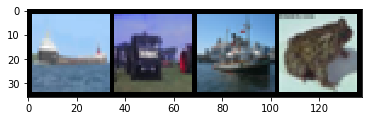

Valores Esperados  ship truck  ship  frog
Valores Obtenidos:  plane truck  ship  frog


In [25]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Valores Esperados', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = RedCIFAR.forward(images)
_, predicted = torch.max(outputs, 1)
print('Valores Obtenidos: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

## Ejercicios:
    -- Crea las funciones necesarias para poder introducir datos concretos a la red (una vez ya entrenada) y obtener el resultado que esta devuelve.
    -- Con la red neuronal entrenada obten la matriz de confusion de ambos conjuntos (entrenamiento y prueba) con las 10 clases posibles y muestrala.
    
## Extra:
    -- Despues de cada MaxPool normaliza las salidas y contrasta el rendimiento de la red.
    -- Graficar las imagenes del conjunto de datos bajo demanda.
    -- Muestra los filtros aprendidos.

# Precisíon del Modelo:

In [26]:
#Funciones auxiliares
def matrizDeConfusion:
    pass

def contarCorrectas(net,batch,labels,func=None):
    '''Dado un batch y sus etiquetas, cuenta el numero de respuestas
    correctas de una red, el parametro func aplica una modificacion al 
    tensor que contiene los datos'''
    
    if(func!=None):
        batch=func(batch)
        salidas=net(batch)
    else:
        salidas=net(batch)
    respuestas=salidas.max(dim=1)[1]
    cantidadCorrectas=(respuestas==labels).sum()
    return cantidadCorrectas
    
def calcularPrecisionGlobal(net,data_loader,batch_size,func=None,cuda=False):
    '''Calcula la precision de una red dado un data_loader,
    recive una funcion que transforma los datos en caso de ser necesario'''
    correctas=0
    for (images,labels) in data_loader:
        if(cuda and torch.cuda.is_available()):
            images=images.cuda()
            labels=labels.cuda()
        correctas+=contarCorrectas(net,images,labels,func)        
    correctas=correctas.data.tolist()
    return (100*correctas)/(len(data_loader)*batch_size)

In [28]:
prec_train =calcularPrecisionGlobal(RedCIFAR,trainloader,4)
prec_val   =calcularPrecisionGlobal(RedCIFAR,testloader,4)
print("Precision en conjunto de entrenamiento: %.4f%%"%(prec_train))
print("Precision en conjunto de validacion: %.4f%%"%(prec_val))

Precision en conjunto de entrenamiento: 61.8820%
Precision en conjunto de validacion: 59.4900%


In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])



In [23]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

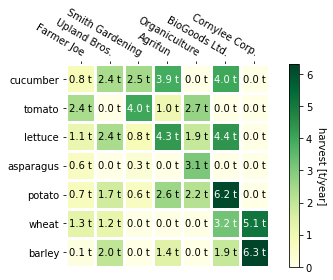

In [24]:
fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()